In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
%matplotlib inline
import glob
import emcee
from math import log
import corner

/Users/ih64/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
"""
Set up the likelihood function.  Inputs are the parameter vector, and then x, y, and yerr. 
"""

def lnlikelihood(pars, x, y, yerr):
    """ 
    Takes the current values of the parameters (pars), plus the data (x, y, yerr) and returns
    ln(likelihood) for the current parameter values
    """
    y_model = pars[0] + pars[1]*x + pars[2]*(x**2) + pars[3]*(x**3)
    lnl = -(y -y_model)**2/yerr**2
    return lnl.sum()

In [3]:
"""
Set up the priors.  These can be really uninformative, but if you have some idea of what
the "correct" answer is, you can put in a more restrictive prior.
For this example, we will put in really broad uniform priors, even though we know what the
"right" answer is

So, we will put the following priors
   a_0:  -20 to +20
   a_1:  -5 to +5
In reality, this should give us priors of P(a_0) = 1/40. and p(a_1) = 1/10. for the relevant
 regions and P = 0 outside them.  However, these constant values cancel out in some sense
 since we are just doing a comparison of relative probabilities.  So, just set the priors
 to 1.0 in the "good" region.
"""
def lnprior(pars):
    #we have some intuition for the first three parameters from previous work
    #we use flat priors from 30% below and above the previous results as priors
    #for these parameters
    a0_init=-2.07890788e+03
    a1_init=6.85415206e-01
    a2_init=-7.70324311e-06
    
    a0_cond=a0_init + a0_init < pars[0] < a0_init - a0_init
    a1_cond=a1_init - a1_init*3 < pars[1] < a1_init + a1_init*3
    a2_cond=a2_init + a2_init*100 < pars[2] < a2_init - a2_init*100
    
    #we have no information about the last one, so we will search 20 above and below zero
    if a0_cond and a1_cond and a2_cond and -3. < pars[3] < 3. :
        return 0.0 # Since log(1) = 0
    else:
        return -np.inf

In [4]:
"""
Set up the unnormalized posterior probability function that is the product of the
likelihood and the priors.
"""

def lnprob(pars, x, y, yerr):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(pars, x, y, yerr)

In [5]:
table=ascii.read('wavecal.txt')
x = table['wavelength'].data
y = table['x_postion'].data
yerr=np.ones(len(x))*.4
#plt.errorbar(x,y,yerr,fmt='bo')

In [6]:
nwalkers=200
ndim=4

a0_init=-2.07890788e+03
a1_init=6.85415206e-01
a2_init=-7.70324311e-06

a0_0= a0_init + (2*np.random.random_sample(nwalkers) - 1)
a1_0= a1_init + 1e-2 * (2*np.random.random_sample(nwalkers) - 1)
a2_0= a2_init + 1e-7 * (2*np.random.random_sample(nwalkers) - 1)
a3_0=2*np.random.random_sample(nwalkers) - 1
p0=np.array([a0_0,a1_0,a2_0,a3_0]).T

niter=1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

""" 
Take the initial guesses and then do a 'burn-in' to get the walkers to a better
location in parameter space
"""
nburn = 200
pos, prob, state = sampler.run_mcmc(p0, nburn)

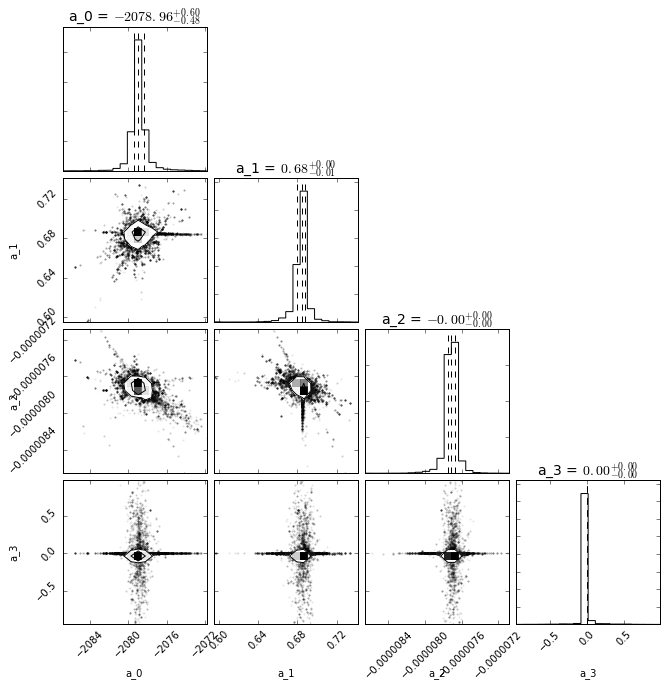

In [7]:
samples = sampler.chain.reshape((-1,ndim))
plt.figure(figsize=(9,9))
fig = corner.corner(samples,labels=['a_0','a_1','a_2','a_3'],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,title_kwargs={"fontsize": 14})

In [8]:
"""
Now run the MCMC for real.
"""
sampler.reset()
niter = 5000
mcmc = sampler.run_mcmc(pos, niter, rstate0=state)

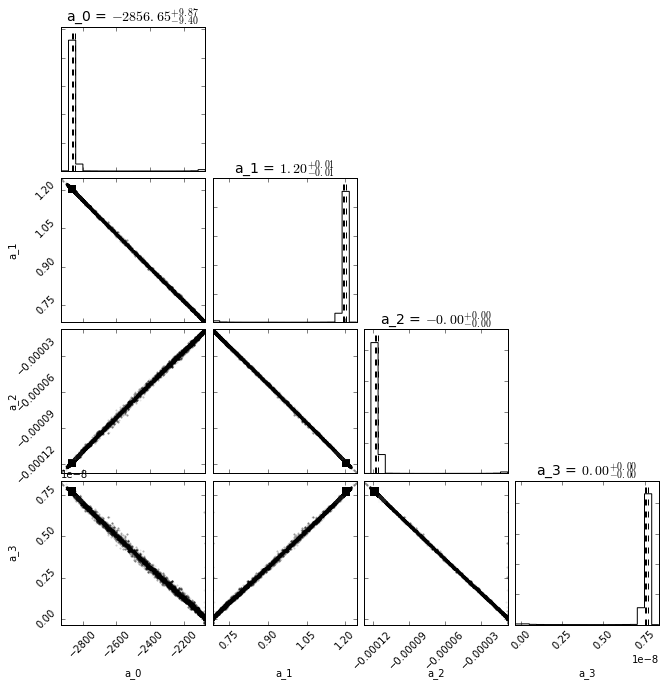

In [9]:
samples = sampler.chain.reshape((-1,ndim))
plt.figure(figsize=(9,9))
fig = corner.corner(samples,labels=['a_0','a_1','a_2','a_3'],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,title_kwargs={"fontsize": 14})


a1 =  -0.0001.
  68 percent CL:  -0.0001 -  -0.0001



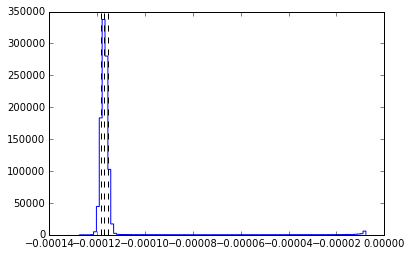

In [10]:
""" Now do a1 """
a2s = sampler.flatchain[:,2]
tmp = plt.hist(a2s,bins=100,histtype='step')

""" Estimate the 68% range, as well as the median point """
a2s.sort()
a2m = a2s[int(0.16 * a2s.size)]
a2p = a2s[int(0.84 * a2s.size)]
a2med = a2s[int(0.5 * a2s.size)]
plt.axvline(a2m,color='k',linestyle='dashed')
plt.axvline(a2p,color='k',linestyle='dashed')
plt.axvline(a2med,color='k',linestyle='dashed')
print ''
print 'a1 = %8.4f.' % a2med
print '  68 percent CL: %8.4f - %8.4f' % (a2m,a2p)
print ''

In [11]:
a3s = sampler.flatchain[:,3]
""" Estimate the 68% range, as well as the median point """
a3s.sort()
a3m = a3s[int(0.16 * a2s.size)]
a3p = a3s[int(0.84 * a2s.size)]
a3med = a3s[int(0.5 * a2s.size)]
a3med

7.5885446806850181e-09

In [12]:
samples[:, 3] = np.exp(samples[:, 3])
a_vector = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [13]:
for i in xrange(0,4):
    print a_vector[i]

(-2856.6540455208801, 9.8673266350970152, 9.3970732590059924)
(1.1972074356939999, 0.0061361969813389372, 0.0064414019951211099)
(-0.00011700292355879178, 1.3700483449895061e-06, 1.3046750101283858e-06)
(1.0000000075885445, 9.0403684538387097e-11, 9.4894536672995855e-11)


## Problem 2

In [14]:
def sigmaClip(data, nsigma, call=1):
    '''sigma clipping algorithm. recieves a numpy array, identifies mean, std, discards elements
    above or below nsigma*std the mean, repeat until no more elements are outside threshold.
    
    python is notoriously slow with loops. instead we implement a recursive algorithm.
    if elements have been discarded, the function will call itself and continue to do so
    until there are no more elements outside of threshold
    
    inputs:
        data: a 1d numpy array
        nsigma: the number of sigma away from the mean you want to clip off
        call: counts the number of recursive call the function makes. 
    outputs: 
        data: the surviving elements from input data
    '''
    
    #calculate the mean, std, and threshold
    mean=data.mean()
    std=data.std()
    threshold=nsigma*std
    
    #define the upper limit
    up_thresh=mean+threshold
    #define lower limit
    down_thresh=mean-threshold
    
    #create the mask to identify elements between thresholds
    good_mask= ((data <= up_thresh) & (data >= down_thresh))

    #define the testcase. if this is true the program will exit
    #if there are no elements above or below threshold, we're done.
    #print out the mean and std, then return the clipped array.
    #finally, return the masked array 
    if data[~good_mask].size == 0:
        print "after %i recursive calls, we have no more elements outside threshold" %(call)
        print "the mean and std of the final clipped array are %.5f and %.5f respectively" %(data.mean(), data.std())
        return
    
    #if that's not the case, recurse on the subproblem. 
    #keep using the same nsigma the user defined in the very first call
    #incrament the call by one so we can keep track of how many recursive calls the function makes
    #then the function will call itself on the clipped version of the data array it recieved
    else:
        call+=1
        return sigmaClip(data[good_mask], nsigma,call=call)

In [15]:
def dark_median(darks):
    '''
    calculate the median flat field image
    
    input:
        darks: a python list containing the paths to the darks you want to combine
        
    output:
        dark_median: the median dark current image
    '''
    n=len(darks)

    #a temporary list to hold the image data
    dark_data=[]
    
    #dump the image data to the list
    for i in xrange(0,n):
        hdulist=fits.open(darks[i])
        data=hdulist[0].data
        dark_data.append(data)
        hdulist.close()
    
    #turn our list of image data into an array
    dark_data_arr=np.array(dark_data)

    #calculake the median flat
    dark_median=np.median(dark_data_arr, axis=0)
    return dark_median

def pipeline(sci_im, darks, flats, display=True):
    #get the image data for the science image
    hdulist=fits.open(sci_im)
    sci_im_data=hdulist[0].data
    hdulist.close()
    
    #calculate the median dark
    dark_median=im_med(darks)
    
    #do the dark subtraction
    dark_sub=sci_im
    
    avg_flat=flat_combine(flats)
    return avg_flat

In [16]:
#get the image data for the science image
hdulist=fits.open('NGC4874_T10_2010_V_1.fits')
sci_im_data=hdulist[0].data
hdulist.close()

#calculate the median dark
darks=glob.glob('Dark*.fits')
med_dark_im=dark_median(darks)

#do the dark subtraction
sci_im_darksub=sci_im_data - med_dark_im

In [17]:
sigmaClip(sci_im_darksub,3)

after 4 recursive calls, we have no more elements outside threshold
the mean and std of the final clipped array are 439.67860 and 40.49545 respectively


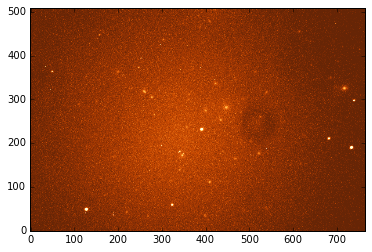

In [18]:
plt.imshow(sci_im_darksub, vmin=(439.67860 - 40.49545),
           vmax=(439.67860 + 10*40.49545), origin='lower',cmap='YlOrBr_r')

In [19]:
def flat_combine(flats):
    '''
    make a combined flat field image. each flat images is normalized by its mean. 
    then the normalized flats are averaged
    
    input:
        flats: a python list to the paths of the flats you wish to combine
    output:
        avg_flat: the average of the median-normalized flats
    '''
    parent_flat=[]

    for i in xrange(0,len(flats)):
        hdulist=fits.open(flats[i])
        parent_flat.append(hdulist[0].data)
        hdulist.close()


    #convert this to a numpy array
    parent_flatAr=np.array(parent_flat)
    #now we can quickly calculate the medians
    medians=np.median(parent_flatAr, axis=(1,2))
    
    #normalize each flat by its median
    normalized_flats=[]
    for i in xrange(0,len(flats)):
        normalized_flats.append(parent_flatAr[i]/medians[i])
    
    #make it an array and quickly calculate the mean flat
    avg_flat=np.array(normalized_flats).mean(axis=0)
    return avg_flat

In [20]:
flats=glob.glob('/Users/ih64/Desktop/ast266_data_analysis/HW4/Flat*')
avg_flat=flat_combine(flats)

sci_dark_flat= sci_im_darksub / avg_flat

In [21]:
sigmaClip(sci_dark_flat, 3)

after 11 recursive calls, we have no more elements outside threshold
the mean and std of the final clipped array are 438.31398 and 23.74130 respectively


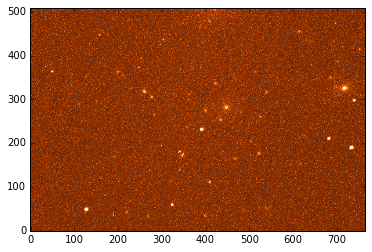

In [22]:
plt.imshow(sci_dark_flat, vmin=(438.31398-23.74130),
           vmax=(438.31398 + 10*23.74130), origin='lower',cmap='YlOrBr_r')